In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from xeb import (random_unitary, simulate_probability, quantum_sample_probability,
                 random_bitstring_probs, fidelity_xeb, fidelity_xeb_noisy)

## Background

#### QC Intro

A quick introduction to quantum states and unitary operations

In [2]:
# the state of N qubits is a complex vector of dimension 2^N
n_qubits = 2
dimension = 2 ** n_qubits
state = [1j, 0, 0, 0]

def print_probs(state, n_qubits):
    # the elements of this state are squared to calculate outcome probabilities
    for bitstring in range(n_qubits ** 2):
        probability = np.abs(state[bitstring]) ** 2

        print("Bitstring", format(bitstring, "0" + str(n_qubits) + "b"), " has probability ", probability)
    print()

print_probs(state, n_qubits)
# an example with a "superposition" over outcomes
print_probs([0, -1j / np.sqrt(2), 0, 1 / np.sqrt(2)], n_qubits)

# evolution is then given by a unitary matrix
identity = np.array([[1, 0], [0, 1]]) # identity on one qubit
flip = np.array([[0, 1], [1, 0]]) # a flip or X-gate on one qubits
flip_first = np.kron(flip, identity) # tensor products make this a two qubit operation

new_state = flip_first@state
print_probs(new_state, n_qubits)

flip_second = np.kron(identity, flip)
print_probs(new_state, n_qubits)

# if we start in the state with all qubits in zero
# then we can take a shortcut to get the probabilities of any particular bitstring
all_zeros = [1] + [0]*(dimension-1)
bs = np.random.choice(range(dimension))
assert (flip_second@all_zeros)[bs] == flip_second[bs, 0]

Bitstring 00  has probability  1.0
Bitstring 01  has probability  0
Bitstring 10  has probability  0
Bitstring 11  has probability  0

Bitstring 00  has probability  0
Bitstring 01  has probability  0.4999999999999999
Bitstring 10  has probability  0
Bitstring 11  has probability  0.4999999999999999

Bitstring 00  has probability  0.0
Bitstring 01  has probability  0.0
Bitstring 10  has probability  1.0
Bitstring 11  has probability  0.0

Bitstring 00  has probability  0.0
Bitstring 01  has probability  0.0
Bitstring 10  has probability  1.0
Bitstring 11  has probability  0.0



#### Porter-Thomas distribution

Fix a bitstring, sample several random quantum programs, and record the ideal probability of sampling this bitstring. The distribution over these ideal probabilities gives us the Porter-Thomas distribution.

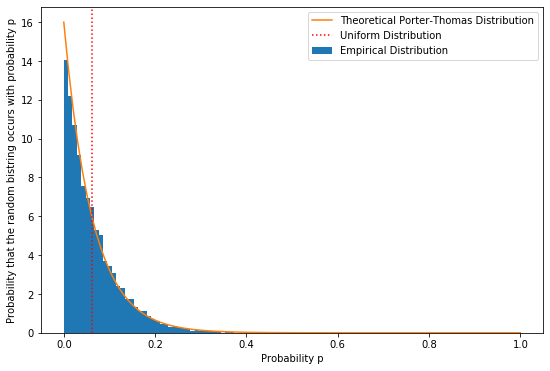

In [3]:
n_qubits = 4
porter_thomas = quantum_sample_probability(n_qubits, 10_000)

# theoretical Porter-Thomas distribution
dim = 2**n_qubits
xspace = np.linspace(0.0, 1.0, 100)
yspace = dim * np.exp(-dim*xspace)

# plot both empirical and theoretical calculations
plt.figure(figsize=(9, 6))
plt.hist(porter_thomas, bins=50, density=True, label='Empirical Distribution')
plt.plot(xspace, yspace, label='Theoretical Porter-Thomas Distribution')
# plot the uniform distribution for reference
plt.axvline(x=1/dim, linestyle='dotted', color='r', label='Uniform Distribution')

plt.xlabel("Probability p")
plt.ylabel("Probability that the random bistring occurs with probability p")
plt.legend(loc='best')
plt.show()

#### Probability distributions of random bitstrings

This time, we won't fix the bitstring in advance but rather sample it from the random quantum program, and then record its ideal probability. The distribution of these ideal probabilities is then plotted below.

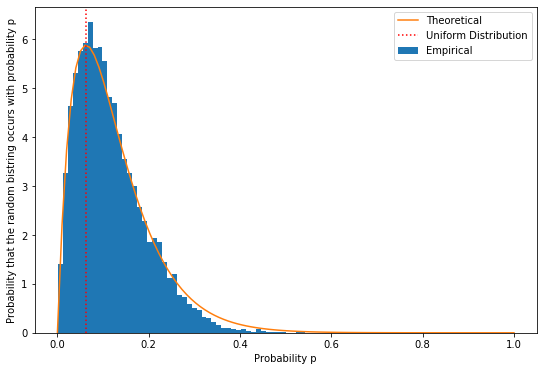

In [4]:
rand_bb_probs = random_bitstring_probs(n_qubits, 10_000)
yspace = xspace*(dim**2)*np.exp(-dim*xspace)

# plot both empirical and theoretical calculations
plt.figure(figsize=(9, 6))
plt.hist(rand_bb_probs, bins=50, density=True, label='Empirical')
plt.plot(xspace, yspace, label='Theoretical')
# plot the uniform distribution for reference
plt.axvline(x=1/dim, linestyle='dotted', color='r', label='Uniform Distribution')

plt.xlabel("Probability p")
plt.ylabel("Probability that the random bistring occurs with probability p")
plt.legend(loc='best')
plt.show()

## Calculations of the Cross-Entropy Benchmark Fidelity

#### F_XEB of ideal quantum processor

First, we'll pick a large number of random quantum programs, and draw one sample each from those programs. The resultant F_XEB has low variance (for a sufficiently large number of random quantum programs) compared to the choice of these parameters reported in the Nature paper.

In [5]:
# sample f_xeb using parameters giving comparitively low-variance result
n_qubits = 4
dim = 2**n_qubits
f_xeb = fidelity_xeb(n_qubits=n_qubits, trials=10**4, n_samples=10**0, sampler=simulate_probability)
print("Empirical FXEB: ", f_xeb)
print("Theoretical FXEB: ", dim*(2/(dim+1)) - 1)

Empirical FXEB:  0.876306861535801
Theoretical FXEB:  0.8823529411764706


Next, we'll run the same calculation, this time using the parameters from the supremacy paper appearing in Nature.

In [6]:
# sample f_xeb using the same parameters as in the Google paper
n_qubits = 4
dim = 2**n_qubits
f_xeb = fidelity_xeb(n_qubits=n_qubits, trials=10, n_samples=10**5, sampler=simulate_probability)
print("Empirical FXEB: ", f_xeb)
print("Theoretical FXEB: ", dim*(2/(dim+1)) - 1)

Empirical FXEB:  0.8144051535557424
Theoretical FXEB:  0.8823529411764706


#### F_XEB of uniform sampler

As a reference, we compare against a uniform sampler.

In [7]:
def unif_dist(unitary, bitstring):
    return 1/dim # all bitstrings have the same probability
unif_xeb = fidelity_xeb(n_qubits=n_qubits, trials=10, n_samples=10**5, sampler=unif_dist)
print("Empirical FXEB of a uniform sampler: ", unif_xeb)
print("Theoretical FXEB of a uniform sampler: ", 0.0)

Empirical FXEB of a uniform sampler:  -0.000531967620212459
Theoretical FXEB of a uniform sampler:  0.0


#### F_XEB of a noisy quantum processor

Depolarizing noise changes the value of F_XEB.

In [8]:
# run the noisy experiment
p = 0.7
n_qubits = 4
dim = 2**n_qubits
noisy_xeb = fidelity_xeb_noisy(n_qubits=4, trials=10**4, n_samples=10**0, prob_no_error=p)
print("Empirical FXEB of a noisy simulation: ", noisy_xeb)
print("Theoretical FXEB of a noisy simulation: ", p*(dim-1)/(dim+1))

Empirical FXEB of a noisy simulation:  0.6087378676438175
Theoretical FXEB of a noisy simulation:  0.6176470588235294
